In [8]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [9]:
df = pd.read_csv('SE_SUMMARY.csv')
df.head()

,year_,country,zone_id,month_grouped,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
0,2021,Sweden,SE,1,6077.28,8227.87,35.39,25788.29,26830.34,4.04,70.26,98.68
1,2021,Sweden,SE,2,8227.87,3315.57,-59.70,26830.34,22847.66,-14.84,69.36,98.14
2,2021,Sweden,SE,3,3315.57,2704.52,-18.43,22847.66,21324.25,-6.67,68.81,99.13
3,2021,Sweden,SE,4,2704.52,3829.70,41.60,21324.25,23180.54,8.71,69.06,99.26
4,2021,Sweden,SE,5,3829.70,2783.95,-27.31,23180.54,21351.22,-7.89,69.87,99.04


In [10]:
df.dtypes

year_                             int64
country                          object
zone_id                          object
month_grouped                     int64
total_direct_carbon_emission    float64
next_direct_carbon_emission     float64
direct_decrease_or_increase     float64
total_lca_carbon_emission       float64
next_lca_carbon_emission        float64
lca_decrease_or_increase        float64
avg_renewable_percentage        float64
avg_low_carbon_percentage       float64
dtype: object

In [11]:
month_names = {
    1: "January",
    2: "February",
    3: "March",
    4: "April",
    5: "May",
    6: "June",
    7: "July",
    8: "August",
    9: "September",
    10: "October",
    11: "November",
    12: "December"
}

df['month_grouped'].astype('str')
df['month_grouped'] = df['month_grouped'].map(month_names)
df.head()

,year_,country,zone_id,month_grouped,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
0,2021,Sweden,SE,January,6077.28,8227.87,35.39,25788.29,26830.34,4.04,70.26,98.68
1,2021,Sweden,SE,February,8227.87,3315.57,-59.70,26830.34,22847.66,-14.84,69.36,98.14
2,2021,Sweden,SE,March,3315.57,2704.52,-18.43,22847.66,21324.25,-6.67,68.81,99.13
3,2021,Sweden,SE,April,2704.52,3829.70,41.60,21324.25,23180.54,8.71,69.06,99.26
4,2021,Sweden,SE,May,3829.70,2783.95,-27.31,23180.54,21351.22,-7.89,69.87,99.04


In [12]:
df.iloc[:, 4:].corr()

,total_direct_carbon_emission,next_direct_carbon_emission,direct_decrease_or_increase,total_lca_carbon_emission,next_lca_carbon_emission,lca_decrease_or_increase,avg_renewable_percentage,avg_low_carbon_percentage
total_direct_carbon_emission,1.000000,-0.087167,-0.259304,0.866561,-0.369135,-0.215724,-0.012471,-0.933397
next_direct_carbon_emission,-0.087167,1.000000,0.670781,0.047883,0.810716,0.639220,-0.017514,0.003886
direct_decrease_or_increase,-0.259304,0.670781,1.000000,-0.264785,0.410192,0.964864,0.051698,0.262494
total_lca_carbon_emission,0.866561,0.047883,-0.264785,1.000000,-0.077702,-0.262020,0.066141,-0.896063
next_lca_carbon_emission,-0.369135,0.810716,0.410192,-0.077702,1.000000,0.381090,0.025511,0.182049
lca_decrease_or_increase,-0.215724,0.639220,0.964864,-0.262020,0.381090,1.000000,0.052908,0.216658
avg_renewable_percentage,-0.012471,-0.017514,0.051698,0.066141,0.025511,0.052908,1.000000,0.024164
avg_low_carbon_percentage,-0.933397,0.003886,0.262494,-0.896063,0.182049,0.216658,0.024164,1.000000


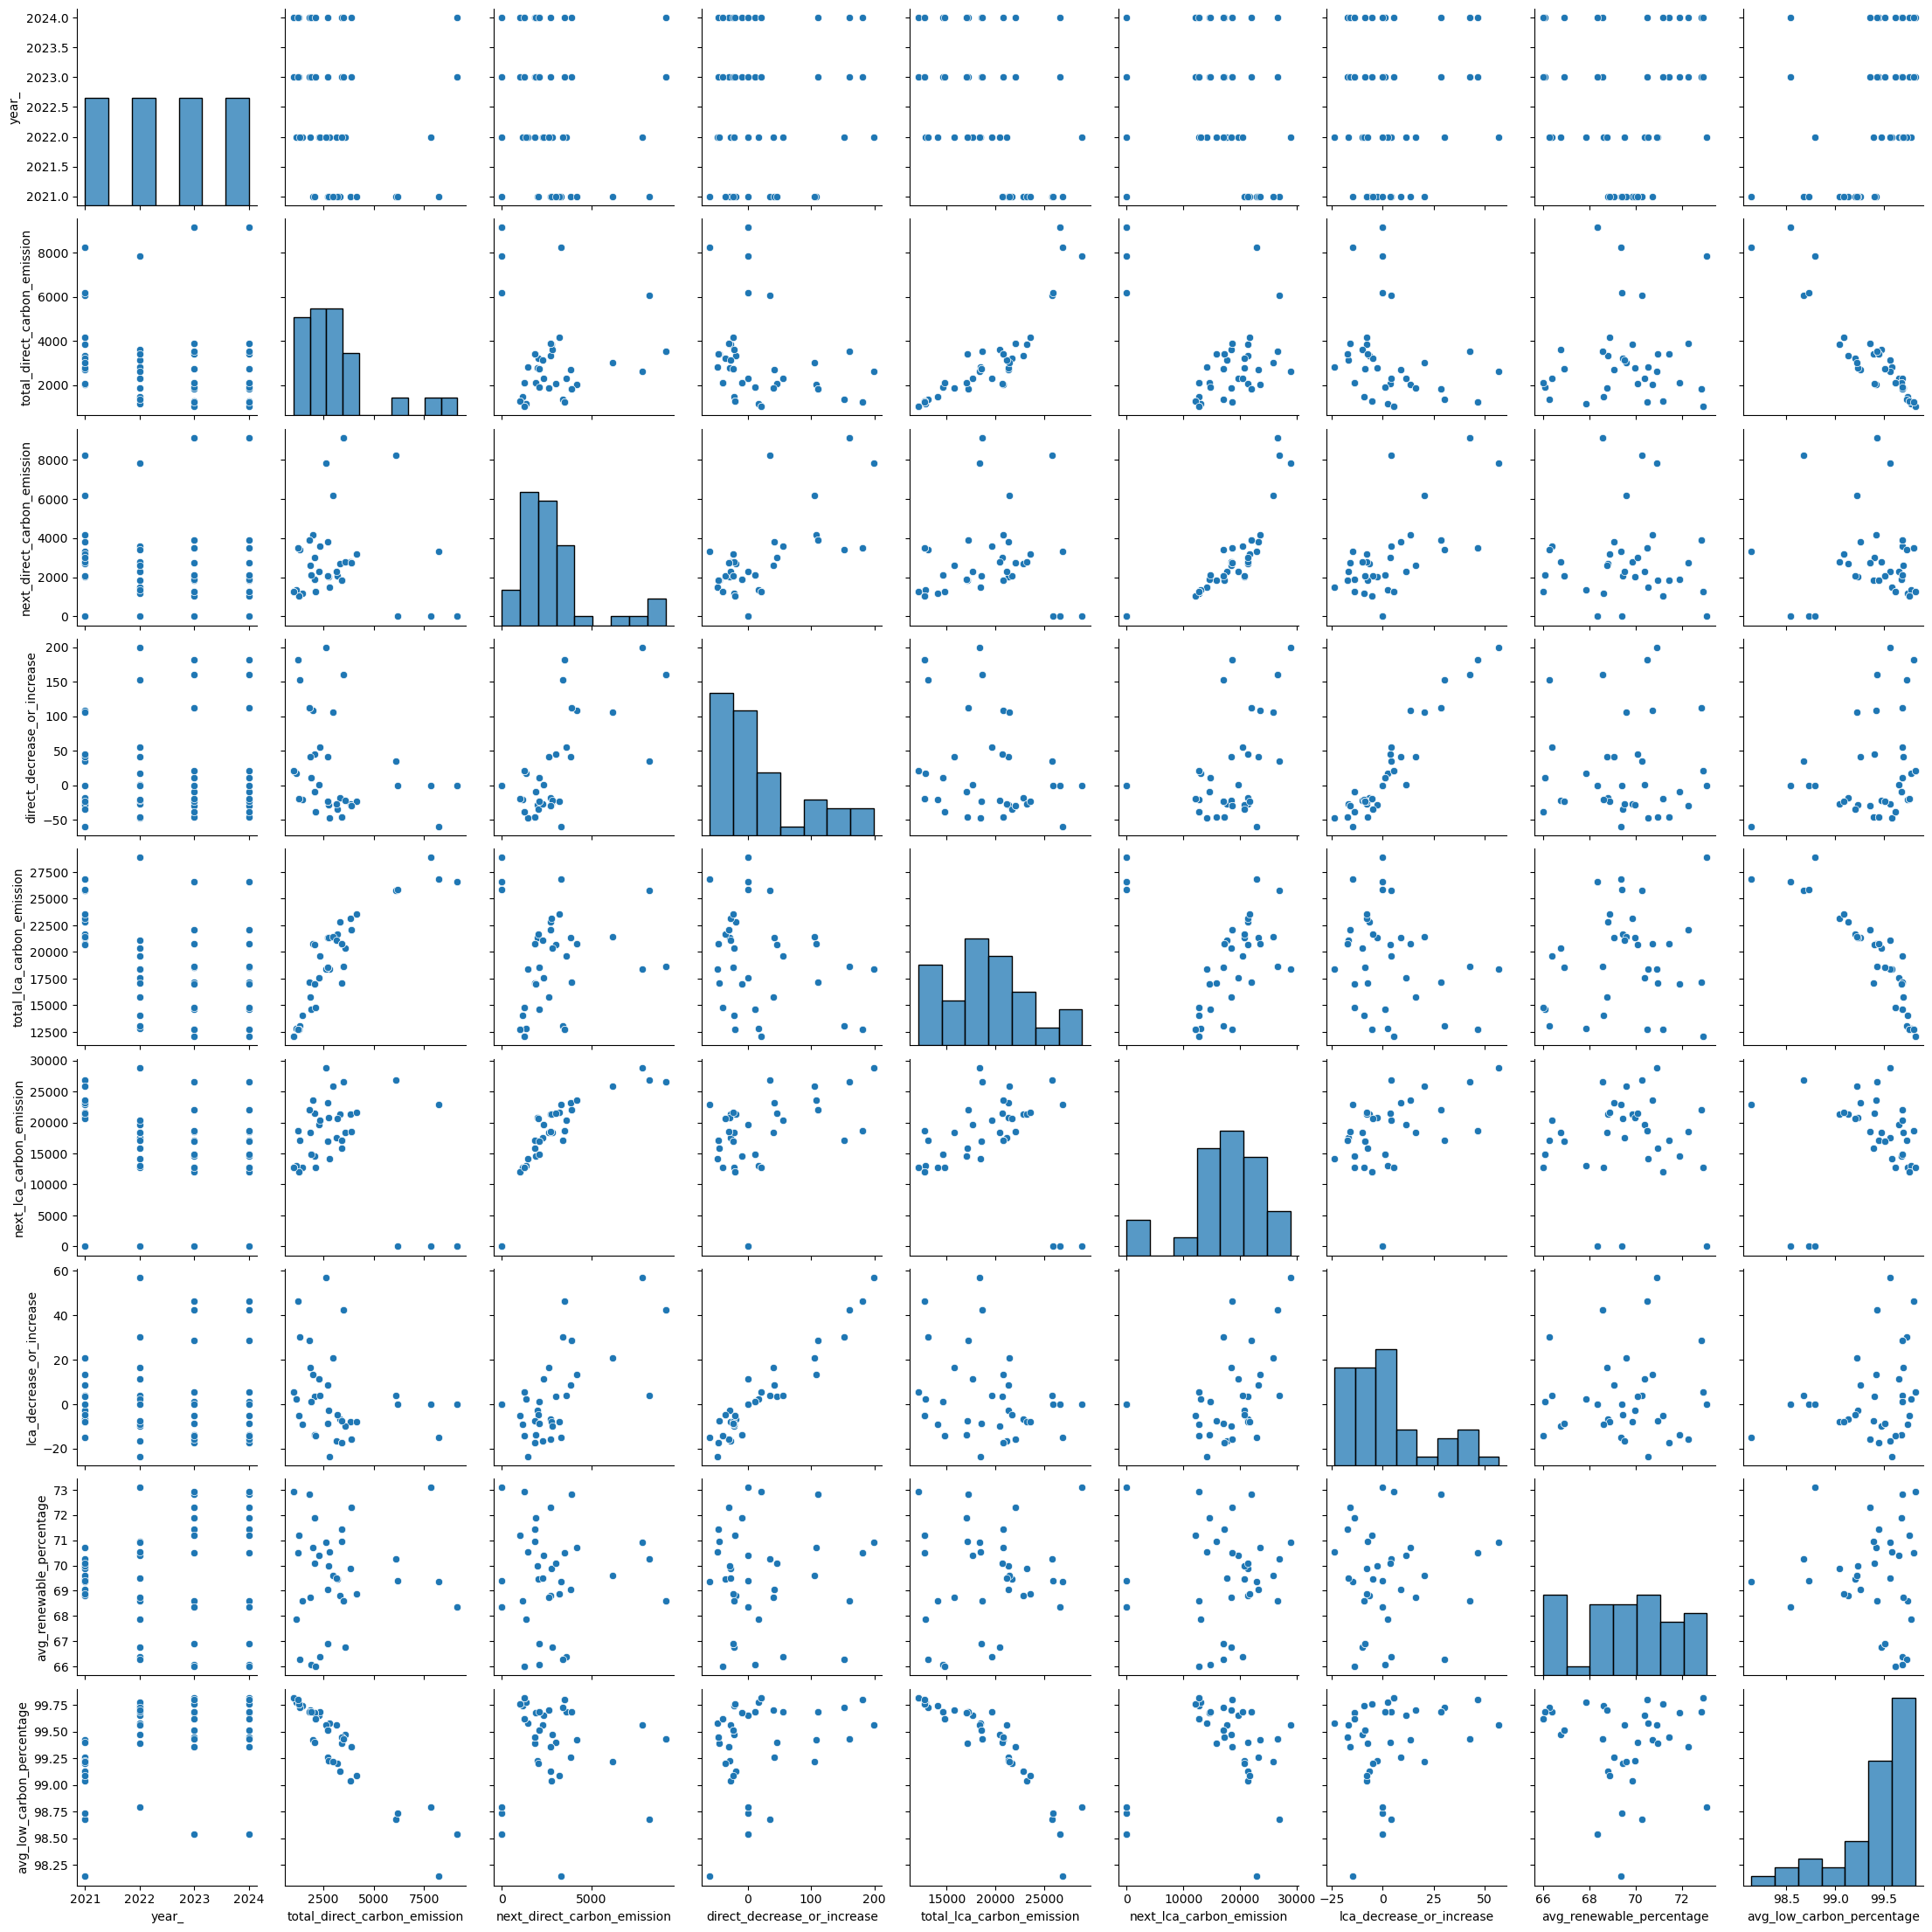

In [13]:
sns.pairplot(df)

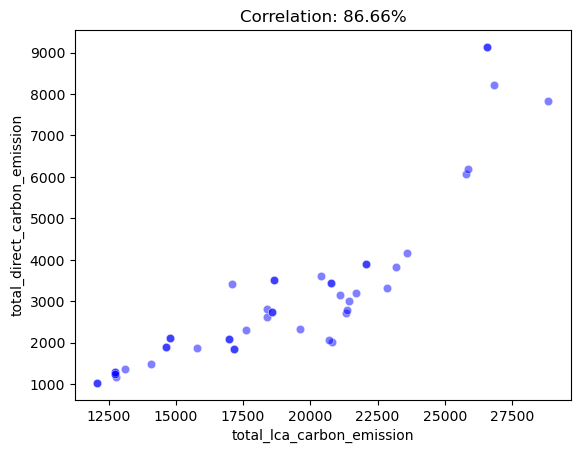

In [14]:
correlation = df[['total_lca_carbon_emission', 'total_direct_carbon_emission']].corr().iloc[0, 1]

sns.scatterplot(x='total_lca_carbon_emission', y='total_direct_carbon_emission', data=df, color='blue', alpha=0.5)
plt.title(f'Correlation: {correlation*100:.2f}%')
plt.show()